In [1]:
# GPU Reset if needed

from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [2]:
# Parameters

base_directory = "i:/image_classify/" # base directory
image_directory = base_directory + "dataset_cleaned_part1" # image directory
image_size  = (224, 224) # preprocessing image size for model input to match with input_tensor in the model
classify_names = ["type1_male", "type2_male", "type3_male", "type4_male","type1_female", "type2_female", "type3_female", "type4_female"] # class names to be classified into (same as sub folder names with images in different classes)

batch_size = 25 # number of images per batch to be processed

shuffle_value = True # whether to shuffle the input images
seed_value = 1337 # seed value to input image pipeline
epochs = 50 # number of maximum epochs to run

In [3]:
# Change to base directory

import os
os.chdir(base_directory)
print("base directory : " + os.getcwd())

base directory : i:\image_classify


In [4]:
# Import Tensorflow and related libraries

import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate


from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

print("TensorFlow version : " + tensorflow.__version__)

TensorFlow version : 2.9.0-dev20220102


In [5]:
# Display available GPUs

physical_devices = tensorflow.config.list_physical_devices('GPU')
for gpu in physical_devices:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [6]:
# Enable Memory Growth

if physical_devices != []:
    tensorflow.config.experimental.set_memory_growth(physical_devices[0], True)
    physical_devices[0]

In [7]:
# Create pipeline to load images

train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory( # train image dataset
    image_directory,
    labels='inferred', 
    label_mode='int',
    class_names=classify_names,     
    validation_split=0.3,
    subset="training",
    shuffle=shuffle_value,
    seed=seed_value,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tensorflow.keras.preprocessing.image_dataset_from_directory( # validation image dataset
    image_directory,
    labels='inferred', 
    label_mode='int', 
    class_names=classify_names,    
    validation_split=0.3,
    subset="validation",
    shuffle=shuffle_value,
    seed=seed_value,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 26783 files belonging to 8 classes.
Using 18749 files for training.
Found 26783 files belonging to 8 classes.
Using 8034 files for validation.


In [8]:
# Train data augmentation to get more variations

data_augmentation = tensorflow.keras.Sequential(
    [
        tensorflow.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), # horizontal flipping
        tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.1),     # random rotation
    ]
)

augmented_train_ds = train_ds.map( lambda x, y: (data_augmentation(x, training=True), y)) # get the augemted training data pipeline


In [9]:
# Using CPU and RAM, combining "type" and "gender" models together and save
# This is only done to overcome limited 3 GB VRAM of GTX1060 3GB

with tensorflow.device('/cpu:0'):
    models1 = load_model('gender.h5')
    models1._name = "gender"
    
    models2 = load_model('type.h5')
    models2._name = "type"

    input_tensor = Input((224, 224, 3))
    output_tensor = [models1(input_tensor) , models2(input_tensor)]
    concat1 = Concatenate()(output_tensor) 
    dense1 = Dense(8, activation='softmax')(concat1)    
    output = dense1

    combined_model = Model(inputs=input_tensor, outputs=output)
    combined_model._name = "identify"

    for layer in combined_model.layers:
        if layer.name == "gender":
            layer.trainable = False
        if layer.name == "type":
            layer.trainable = False            

    combined_model.summary() 

    plot_model(combined_model, to_file='combined.png', show_shapes=True, show_layer_names=True)
        
    for i, layer in enumerate(combined_model.layers):
        print(i, layer.name, layer.trainable)
    
    combined_model.save("combined.h5")  


Model: "identify"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 gender (Functional)            (None, 2)            26737538    ['input_1[0][0]']                
                                                                                                  
 type (Functional)              (None, 4)            26739588    ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 6)            0           ['gender[0][0]',          

Model: "identify"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 combined (Functional)       (None, 8)                 53477182  
                                                                 
Total params: 53,477,182
Trainable params: 56
Non-trainable params: 53,477,126
_________________________________________________________________


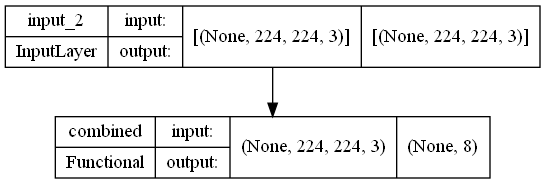

In [10]:
# Load the saved combined model

saved_model = load_model('combined.h5')
saved_model._name = "combined"

# Create a model with inpots and outputs to evaluate
input_tensor = Input((224, 224, 3))
model = Model(inputs=input_tensor, outputs=saved_model(input_tensor))
model._name = "identify"
model.summary()

# Save the model as a png file
plot_model(model, to_file=model._name +'.png', show_shapes=True, show_layer_names=True)

In [11]:
# Show the trainable status of the layers

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_2 True
1 combined True


In [12]:
# Compile the model

model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [13]:
# Tensorboard parameters

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
# Use best weights for the model

early_stopping_monitor = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=6,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

In [15]:
# Training the model

model.fit(
    augmented_train_ds, epochs=epochs, callbacks=[early_stopping_monitor, tensorboard_callback], validation_data=val_ds,
    )


Epoch 1/50
750/750 [==============================] - 276s 356ms/step - loss: 1.6050 - accuracy: 0.5242 - val_loss: 1.0653 - val_accuracy: 0.8999
Epoch 2/50
750/750 [==============================] - 263s 348ms/step - loss: 0.8056 - accuracy: 0.8935 - val_loss: 0.5987 - val_accuracy: 0.9488
Epoch 3/50
750/750 [==============================] - 244s 322ms/step - loss: 0.4946 - accuracy: 0.9459 - val_loss: 0.4011 - val_accuracy: 0.9511
Epoch 4/50
750/750 [==============================] - 244s 322ms/step - loss: 0.3535 - accuracy: 0.9458 - val_loss: 0.3065 - val_accuracy: 0.9510
Epoch 5/50
750/750 [==============================] - 244s 322ms/step - loss: 0.2896 - accuracy: 0.9451 - val_loss: 0.2578 - val_accuracy: 0.9512
Epoch 6/50
750/750 [==============================] - 243s 322ms/step - loss: 0.2510 - accuracy: 0.9466 - val_loss: 0.2304 - val_accuracy: 0.9512
Epoch 7/50
750/750 [==============================] - 243s 321ms/step - loss: 0.2328 - accuracy: 0.9450 - val_loss: 0.2157 -

In [16]:
# Show tensorboard

%load_ext tensorboard
%tensorboard --logdir logs/fit
#%reload_ext tensorboard # just in case tensorboard didn't refresh


Reusing TensorBoard on port 6006 (pid 20472), started 2:26:21 ago. (Use '!kill 20472' to kill it.)

In [17]:
# Calculate preditions for the validation dataset

import numpy as np

y_pred = []  # store predicted labels
y_true = []  # store true labels

for image_batch, label_batch in val_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = - 1))

# Convert the true and predicted labels into tensors
true_categories = tensorflow.concat([item for item in y_true], axis = 0)
predicted_categories = tensorflow.concat([item for item in y_pred], axis = 0)

In [18]:
# Generate confusion matrix

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(true_categories,predicted_categories, normalize='pred')

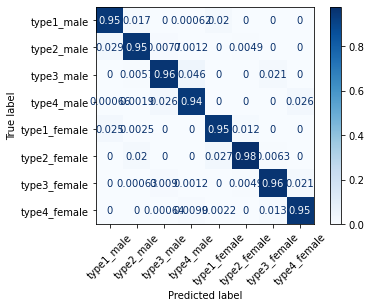

In [19]:
# Plot confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=classify_names)

disp = disp.plot(cmap='Blues', xticks_rotation=45)

plt.show()

In [20]:
# Display accuracy information

from sklearn.metrics import accuracy_score, f1_score

print("Accuracy for validation split: " ,accuracy_score(true_categories, predicted_categories))
print( "F1_score: " + str(f1_score(true_categories, predicted_categories, average='micro')))

Accuracy for validation split:  0.9513318396813543
F1_score: 0.9513318396813543


In [21]:
# Rename model weights to overome bug in Tensorflow 2.3

for i in range(len(model.weights)):
    model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

In [22]:
# Making finally trained layer to untrainable before saving

for layer in model.layers:
    if layer.name == "combined":
        layer.trainable = False

In [23]:
# Saving final model for future use

model.save("identify_final.h5")